# Automating the collocation of mesoscale eddies and BGC-Argo profiles

This tutorial guides you through the process of automating the collocation of mesoscale eddies and BGC-Argo profiles using EddyProfSync. The necessary data has been downloaded and prepared in advance, and you can find the corresponding `.mat` files in the `data` directory.

## Data Sources and Tools

### BGC-Argo Profiles

We obtained BGC-Argo data using the [OneArgo-Mat](https://github.com/NOAA-PMEL/OneArgo-Mat) tool. This versatile tool allows us to download and perform initial quality control on the data. However, they recommend to write own function for perform analyses. For this tutorial, we processed approximately 96 floats in the Southern Ocean, capturing their spatio-temporal locations only to reduce the size of data. Furthermore, to identify profiles that are surfaced in eddies, we only need longitude, latitude and time of profile along with its identifier.

### Mesoscale Eddies

Mesoscale eddies were derived from the META datasets, and their trajectories were processed using Python scripts provided by [AVISO](https://www.aviso.altimetry.fr/en/data/products/value-added-products/global-mesoscale-eddy-trajectory-product/meta3-2-dt.html). Specifically, we truncated Mesoscale Eddies Trajectories for the year 2018, focusing on cyclonic and anticyclonic eddies in the Southern Ocean.

## Workflow Overview

In this tutorial, we demonstrate a streamlined workflow for collocating mesoscale eddies and BGC-Argo profiles. Notably, we illustrate that there is no need to worry about overlapping periods of both datasets when preparing indices, as shown in a previous tutorial (`matchInsituProfiles_stas.ipynb`).

Let's get started!


In [1]:
clear;clc
% Load BGC-Argo data
dir_path = '~/Documents/ToGitHub/EddyProfileCollocator';
load(strcat(dir_path,'/data/', 'sobgcargo_tutorial.mat'))

% Load mesoscale eddies
load(strcat(dir_path,'/data/', 'cycmetaeddies_tutorial.mat'))
load(strcat(dir_path,'/data/', 'acycmetaeddies_tutorial.mat'))

# Adapting Argo Data for EddyProfSync

EddyProfSync requires input in a column array format. However, since Argo data is typically stored by float, we need to extract and organize the spatio-temporal information into an array. To facilitate this process, I've provided two functions designed to retrieve longitude, latitude, and time from the OneArgo-Mat data structure. These functions can be found in the `utils` directory. 


In [2]:
% Add helper functions 
addpath(strcat(dir_path,'/utils/'))
% Retrieve longitude, latitude and time 
[argolon, argolat, argotime] = ra_get_lon_lat_time(data_lmtutorial, floatid_tutorial);
% 
[argolon, argolat, argotime, argodateineddyformat] = ra_getlonlattimeIncol(argolon, argolat, argotime);

# Filtering Virtual Eddies in META dataset

To ensure the integrity of the data, we remove virtual eddies from the Meta dataset, as they may exhibit unusual contours. For this purpose, I've implemented a function named `omitvirtualeddy4mMETA.m`, which should be found in the `utils` directory.


In [3]:
cycvar = omitvirtualeddy4mMETA(cycdata);
acycvar = omitvirtualeddy4mMETA(acycdata);

# Building Indices for BGC-Argo Profiles and Cyclonic Eddies

In the collocation process of BGC-Argo profiles with cyclonic eddies, we'll start by building indices. First, we'll prepare the index for BGC-Argo profiles, followed by the index for cyclonic eddies to streamline the collocation process.

For the BGC-Argo indices, I recommend using the float's WMO and cycle number as indices. Unlike profile IDs, which may not be sequential in the original data, utilizing the float's WMO and cycle number allows us to efficiently extract physical and biogeochemical measurements after collocating. For this purpose, I have provided a function called `myargoindex.m` in the `utils` directory.

In [4]:
% Create new index to match the eddies and argo
% To get only one pressure level
so_cycnum = cellfun(@(x) x(1,:), cyclenum_tutorial, 'UniformOutput', false);
argofidnprofid = myargoindex(floatid_tutorial, so_cycnum);


Next, for the cyclonic eddies indices, we'll utilize the `time` variable to label rows. This approach is useful when we want to collocate eddies and profiles without concerning ourselves with overlapping periods.

It's important to note that while this method serves illustration purposes, it is generally recommended to create overlap data for efficient matching of eddies and surfaced profiles. Nonetheless, EddyProfSync is designed to gracefully handle situations where there are no cyclonic eddies or no profiles to collocate.

In [5]:
% Read time variable from eddies data
cyc_time = cycvar.time + datenum(1950,01,01,00,00,00);

% Number each row for the index
eindex = (1:length(cyc_time))'; % creating row numbers 


Let's collocate cyclonic eddies with BGC-Argo profiles using EddyProfSync. Note, here we will use `speed_contour` as a close boundary of an eddy.

In [6]:
% Get profiles that are surfaced in cyclonic eddies
addpath(strcat(dir_path,'/src/'))

% Get profiles in cyclonic eddies 
[cInprofid, cIneddyidx] = find_profineddy(cycvar, eindex, cyc_time, ...
argolon, argolat, argofidnprofid, argodateineddyformat, 'speed');

Collocating surfaced profile and eddies for: 24-Feb-2012
no eddies or argo found, continue to the next day
Collocating surfaced profile and eddies for: 29-Feb-2012
no eddies or argo found, continue to the next day
Collocating surfaced profile and eddies for: 05-Mar-2012
no eddies or argo found, continue to the next day
Collocating surfaced profile and eddies for: 10-Mar-2012
no eddies or argo found, continue to the next day
Collocating surfaced profile and eddies for: 16-Mar-2012
no eddies or argo found, continue to the next day
Collocating surfaced profile and eddies for: 21-Mar-2012
no eddies or argo found, continue to the next day
Collocating surfaced profile and eddies for: 26-Mar-2012
no eddies or argo found, continue to the next day
Collocating surfaced profile and eddies for: 31-Mar-2012
no eddies or argo found, continue to the next day
Collocating surfaced profile and eddies for: 06-Apr-2012
no eddies or argo found, continue to the next day
Collocating surfaced profile and eddi

In [7]:
% Convert to array from cell array
cycargofpid = cell2mat(cInprofid);
cycindex = cell2mat(cIneddyidx);
clear cIn*

Extract profiles outside of cyclonic eddies to identify profiles in anticyclonic eddies. Removing cyclonic eddies' profiles avoids redundancy in the collocation process. While the overlap of cyclonic and anticyclonic eddies is unlikely due to the accuracy of the tracking algorithm, we won't assume it. Therefore, removing cyclonic eddies' profiles ensures a more precise identification of profiles in anticyclonic eddies.

In [8]:
% Argo profiles that are not in cyclonic eddies
insidecyc = ismember(argofidnprofid, cycargofpid,'rows');
outsidecyc = ~insidecyc;

% Getting corresponding argo informations
outsidecycfpid = argofidnprofid(outsidecyc,:);
outsidecyclon = argolon(outsidecyc);
outsidecyclat = argolat(outsidecyc);
outsidecycday = argodateineddyformat(outsidecyc);

Now its time to do the same for anticylconic eddies

In [9]:
% Prepare EddyIndex for anticyclonic eddies
acyc_time = acycvar.time + datenum(1950,01,01,00,00,00);

% Get eddy index parameter from date variable
eindex = (1:length(acyc_time))'; % to conform  

% collocating argo in anticyclone
[cInprofid, cIneddyidx] = find_profineddy(acycvar, eindex, acyc_time,...
    outsidecyclon, outsidecyclat, outsidecycfpid, outsidecycday, 'speed');

% Convert to array from cellarray 
acycargofpid = cell2mat(cInprofid); 
acycindex = cell2mat(cIneddyidx);
clear cIn*

% Argo profiles that are not in eddies 
insideacyc = ismember(outsidecycfpid, acycargofpid,'rows');
outsideacyc = ~insideacyc;

% Getting corresponding argo informations
outsidecycnacycfpid = outsidecycfpid(outsideacyc,:);
outsidecycnacyclon = outsidecyclon(outsideacyc);
outsidecycnacyclat = outsidecyclat(outsideacyc);
outsidecycncycday = outsidecycday(outsideacyc);

%
disp('Collocated files are ready to be saved!!!')

Collocating surfaced profile and eddies for: 24-Feb-2012
no eddies or argo found, continue to the next day
Collocating surfaced profile and eddies for: 29-Feb-2012
no eddies or argo found, continue to the next day
Collocating surfaced profile and eddies for: 05-Mar-2012
no eddies or argo found, continue to the next day
Collocating surfaced profile and eddies for: 10-Mar-2012
no eddies or argo found, continue to the next day
Collocating surfaced profile and eddies for: 16-Mar-2012
no eddies or argo found, continue to the next day
Collocating surfaced profile and eddies for: 21-Mar-2012
no eddies or argo found, continue to the next day
Collocating surfaced profile and eddies for: 26-Mar-2012
no eddies or argo found, continue to the next day
Collocating surfaced profile and eddies for: 31-Mar-2012
no eddies or argo found, continue to the next day
Collocating surfaced profile and eddies for: 06-Apr-2012
no eddies or argo found, continue to the next day
Collocating surfaced profile and eddi

Let's save all the variables for further analyses in Argo format so that we can retrieve relavent information if and when needed from the Argo data structure. To do so, I have written `ra_saveinargostruct.m` and `ra_mat2argostruct.m`, should be found in the `utils` directory.

In [10]:
% Saving all data in a separate variables for further analyses.
disp('Saving .mat files...')
% NOTE: these functions need column input therefore we converted earlier.. 
% here PROFID is in practice is a cycle number to match the profile. 
% This will save .mat file at the current location.

% Cyclonic eddies
[cycfloatid, cycprofid, cycindices] = ra_saveinargostruct(cycargofpid, cycindex);
save cycargolistsotutorial cycfloatid cycprofid cycindices -v7.3
% Anticyclonic eddies
[acycfloatid, acycprofid, acycindices] = ra_saveinargostruct(acycargofpid, acycindex);
save acycargolistsotutorial acycfloatid acycprofid acycindices -v7.3
% profiles outside eddies
[outfloatid, outprofid] = ra_mat2argostruct(outsidecycnacycfpid);
save outcycnacycsotutorial outfloatid outprofid -v7.3
%
disp('All .mat files are ready to be analysed!!!')

Saving .mat files...
All .mat files are ready to be analysed!!!


## Extracting information from the collocated data

Now, we can retrieve corresponding information from both original data sets related to the collocation. First, we will retrieve Argo data corresponding to collocated profiles for each category, namely, profiles in cyclonic eddies, profiles in anticyclonic eddies, and those outside of eddies. Please find `ra_importdata_interp.m` in the `utils` directory to perform this.

In [11]:
% 
clear;clc

% Path to the main repository
dir_path = '~/Documents/ToGitHub/EddyProfileCollocator';

% Add helper functions
addpath(strcat(dir_path,'/utils/'))

% Qced regional argo data with required variables for the tutorial purpose
load([dir_path, '/data/','sobgcargo_tutorial.mat']) % this is the same data that we have loaded at outset

% Load matched cyclonic eddies and argo profile indices  
load([dir_path,'/tutorials/', 'cycargolistsotutorial.mat'])

% Retrieve Argo profile data corresponding to cyclonic eddies 
cycdataso = ra_importdata_interp(data_lmtutorial, cycfloatid, cycprofid);
% NOTE, here cycprofid is cycle number
save cycbgcsodatatutorial cycdataso cycfloatid cycprofid cycindices -v7.3

% Likewise for anticyclonic eddies
load([dir_path, '/tutorials/' ,'acycargolistsotutorial.mat'])
acycdataso = ra_importdata_interp(data_lmtutorial, acycfloatid, acycprofid);
% NOTE, here acycprofid is cycle number
save acycbgcsodatatutorial acycdataso acycfloatid acycprofid acycindices -v7.3

% Finally, out of cyclonic and anticyclonic eddies - good for background field estimates
load([dir_path, '/tutorials/', 'outcycnacycsotutorial.mat'])
outdataso = ra_importdata_interp(data_lmtutorial, outfloatid, outprofid);
% NOTE, here outprofid is cycle number
save outbgcsodatatutorial outdataso outfloatid outprofid -v7.3

disp('Data are ready to be analysed!!')

F6901583
F5904980
F5904660
F5905135
F5905070
F5905079
F5905073
F5904659
F5905367
F5905072
F5904671
F5905374
F5904662
F5904674
F5904678
F5904677
F5905378
F5904856
F5905369
F5904474
F5904658
F5904661
F5904767
F5904673
F5904685
F5904688
F5904845
F5905368
F5905132
F5904185
F5904763
F5904679
F5905076
F5904846
F5905366
F5905376
F5904854
F5904765
F5904686
F5904180
F5904682
F5904663
F5905375
F5905099
F5905133
F5904695
F5905371
F5904467
F5904658
F5904673
F5904675
F6901004
F5905132
F5904185
F5904765
F5905368
F5904854
F5904682
F5904846
F5904688
F6901583
F5904469
F5905076
F5905079
F5904684
F5905073
F5905378
F5904845
F5904980
F5904843
F5905371
F5904761
F5905376
F5905133
F5904695
F5905366
F5904672
F5904686
F5905370
F5904678
F5904677
F5905072
F5904671
F5904693
F5904842
F5905372
F5905135
F5904657
F5904982
F5905377
F5904660
F5905109
F5905099
F5904661
F5904763
F5904467
F5905131
F5905134
F5904766
F5904474
F5906002
F5905108
F5905071
F5905374
F5903717
F5904104
F5904180
F5904184
F5904185
F5904188
F5904397
F

## Analysing collocated data

Let's delve into the analysis of collocated eddies and BGC-Argo profiles, which we have saved in separate `.mat` files with corresponding eddies and profiles in previous step. To demonstrate the synchronization achieved by the EddyProfSync algorithm, we will start by visualizing through a GIF.

In [12]:
clear;clc
% Set path to the main directory
dir_path = '~/Documents/ToGitHub/EddyProfileCollocator';

% Load matched cyclonic eddies data 
load([dir_path, '/tutorials/', 'cycbgcsodatatutorial.mat'])

% Load matched anticyclonic eddies data
load([dir_path, '/tutorials/', 'acycbgcsodatatutorial.mat'])

% Get logitude, latitude and time for each 
% cyclonic eddies
[cycalon, cycalat, cycatime] = ra_get_lon_lat_time(cycdataso,cycfloatid);
[cycalon, cycalat, cycatime, cycadate] = ra_getlonlattimeIncol(cycalon,cycalat,cycatime);
cycindex = cell2col(cycindices, 'nonans');

% Anticyclonic eddies
[acycalon, acycalat, acycatime] = ra_get_lon_lat_time(acycdataso,acycfloatid);
[acycalon, acycalat, acycatime, acycadate] = ra_getlonlattimeIncol(acycalon,acycalat,acycatime);
acycindex = cell2col(acycindices, 'nonans');

% Load mesoscale eddies trajectory to confirm
load([dir_path,'/data/', 'cycmetaeddies_tutorial.mat'])
load([dir_path,'/data/', 'acycmetaeddies_tutorial.mat'])
cycvar = omitvirtualeddy4mMETA(cycdata);% filtering eddies
acycvar = omitvirtualeddy4mMETA(acycdata); % filtering eddies

GIF for cyclonic eddies.

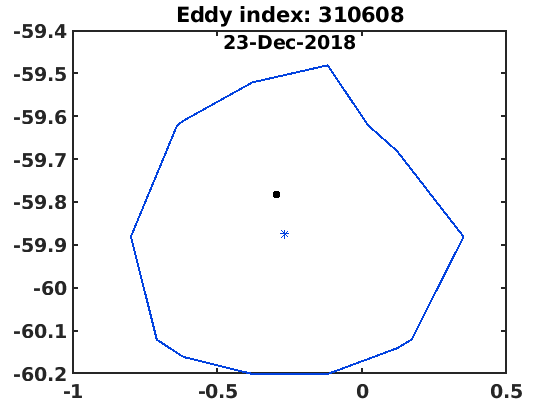

In [13]:
% Prepare GIF for Argo profiled in cyclonic eddies

filename = strcat('BGCArgoInCycloniceddies_tutorial', '.gif');
%
fig = figure(1);

for iee = 1:length(cycindex)
    ceidx = cycindex(iee);
    % Read effective contours
    eloncont = cycvar.speed_contour_longitude(:, ceidx);
    elatcont = cycvar.speed_contour_latitude(:, ceidx);

    % Plotting argo surfaced in
    plot(cycalon(iee), cycalat(iee), '.k', 'MarkerSize',15) % plotting in or on argo profiles
    hold on
    plot(wrapTo180(cycvar.longitude(ceidx)), cycvar.latitude(ceidx), '*', 'Color', rgb('blue'))
    plot(wrapTo180(eloncont), elatcont, '-', 'Color', rgb('blue'), 'LineWidth',1.5)
    
    hold off

    tname = ['Eddy index: ', num2str(ceidx)];
    ntitle([datestr(cycadate(iee))], 'fontsize', 14, 'fontweigh', 'bold')
    title(tname, 'fontsize', 16, 'fontweigh', 'bold')
    set(gca, 'linewi', 1.5, 'fontsize', 14, 'fontweigh', 'bold')
    
    % Capturing the plot as an image
    frame = getframe(fig);
    im = frame2im(frame);
    [imind, cm] = rgb2ind(im, 256);
    
    % Write to the GIF file
    if iee == 1
        imwrite(imind, cm, filename, 'gif', 'Loopcount', inf);
    else
        imwrite(imind, cm, filename, 'gif', 'WriteMode', 'append', 'DelayTime', 1)
    end
 clear frame im imind cm tind
end


Likewise for Anticyclonic eddies

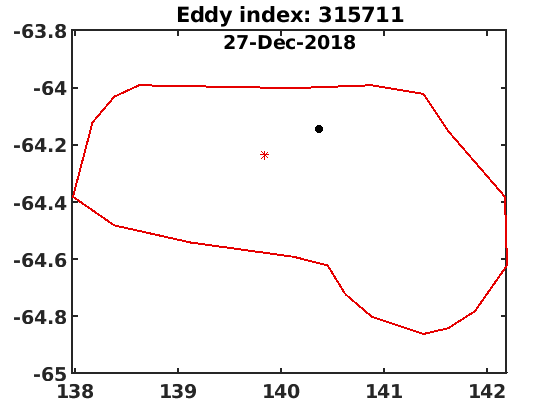

In [14]:
filename = strcat('BGCArgoInAnticycloniceddies_tutorial', '.gif');
%
fig = figure(1);
for iee = 1:length(acycindex)
    ceidx = acycindex(iee);
    % Read effective contours
    eloncont = acycvar.effective_contour_longitude(:, ceidx);
    elatcont = acycvar.effective_contour_latitude(:, ceidx);

    % Plotting argo surfaced in
    plot(acycalon(iee), acycalat(iee), '.k', 'MarkerSize',15) % plotting in or on argo profiles
    hold on
    plot(wrapTo180(acycvar.longitude(ceidx)), acycvar.latitude(ceidx), '*', 'Color', rgb('red'))
    plot(wrapTo180(eloncont), elatcont, '-', 'Color', rgb('red'), 'LineWidth',1.5)
    hold off
    tname = ['Eddy index: ', num2str(ceidx)];
    ntitle([datestr(acycadate(iee))], 'fontsize', 14, 'fontweigh', 'bold')
    title(tname, 'fontsize', 16, 'fontweigh', 'bold')
    set(gca, 'linewi', 1.5, 'fontsize', 14, 'fontweigh', 'bold')
%     pause(2)
    % Capturing the plot as an image
    frame = getframe(fig);
    im = frame2im(frame);
    [imind, cm] = rgb2ind(im, 256);
    
    % Write to the GIF file
    if iee == 1
        imwrite(imind, cm, filename, 'gif', 'Loopcount', inf);
    else
        imwrite(imind, cm, filename, 'gif', 'WriteMode', 'append', 'DelayTime', 1)
    end
 clear frame im imind cm tind
end

![BGC-Argo profiles surfaced in cyclonic eddies](BGCArgoInCycloniceddies_tutorial.gif)

![BGC-Argo profiles surfaced in Anticyclonic eddies](BGCArgoInAnticycloniceddies_tutorial.gif)